In [1]:
#https://plotly.com/python/reference/

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#0d1238'}

import io
import json
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image, clear_output
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

!git -C $directory pull

states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Virgin Islands']

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']
bgcolor = '#0d1238'

Already up to date.


In [149]:
def get_census_info():
    county_populations = pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1")
    county_populations = county_populations[county_populations['SUMLEV'] == 50] # 40 is states, 50 is counties
    county_populations = county_populations[['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019']] # Keep Just population estimate
    county_populations['fips'] = (county_populations['STATE'] * 1000) + county_populations['COUNTY']
    county_populations = county_populations[['fips', 'POPESTIMATE2019']]
    county_populations = county_populations.rename(columns={'POPESTIMATE2019':'pop'})
    county_populations = county_populations.set_index('fips')
    return county_populations

def load_csv(directory, f):
    result = pd.read_csv(directory + f)
    result['date'] = datetime.strptime(f, '%m-%d-%Y.csv')
    return result
    
def get_daily_report_data():
    result = pd.concat([load_csv(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]).reset_index()
    result = result[~np.isnan(result['FIPS'])]
    result['FIPS'] = result['FIPS'].astype(int)
    result = result[~result['Province_State'].isin(['Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands', 'American Samoa'])]
    return result

def get_county_percentages():
    daily_report_data = get_daily_report_data()
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']] # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips']) # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips') # Create the pivot table. 
        .fillna(0)
    )
    df1 = (
        starter[starter >= starter.cummax()]
        .interpolate()
        .diff()
        .rolling(window=7)
        .mean()
        .dropna()
        .T
    )

    df2 = get_census_info()
    return (df1.div(df2.iloc[:,0], axis=0).dropna()) * 100000

def get_allcounties():
    with open(os.getcwd() + '/geojson-counties-fips.json') as response:
        allcounties = json.load(response)
    return allcounties

def draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, legend=None):

    clear_output(wait=True)
    date = row.name
    print(date)
    
    foldername = 'gitignore-county-spread-images'
    filename = '{0}/{1:%Y-%m-%d-%H-%M}.png'.format(foldername, date)
    if store_intermediate_files == True:
        if (not os.path.exists(foldername)):
            os.mkdir(foldername)
        if (os.path.exists(filename)):
            return PILImage.open(filename)
    
    if (legend == None):
        legend=get_legend()
        
    calendar = get_calendar(date.year, date.month, date.day)
        
    local_directory = os.getcwd()

    row = row[row.index.isin([stateid['id'] for stateid in county_geojson['features']])]

    row = row.reset_index().rename(columns={date:'confirmed'})

    for feature in county_geojson["features"]:
        feature["properties"]["FIPS"] = str(int(feature["properties"]["STATE"])) + feature["properties"]["COUNTY"]

    bgcolor = '#0d1238'
    fig = px.choropleth(row, 
                        geojson=county_geojson, 
                        locations='fips', 
                        color='confirmed',
                        color_continuous_scale=colorscale,
                        featureidkey='properties.FIPS',
                        projection='albers usa',
                        title="Where is COVID Spreading?",
                        template='plotly_dark',
                        range_color=[0,zmax],
                        labels={"confirmed": ""}
                      )

    fig.update_geos(
        showcountries=False,
        showcoastlines=True, 
        showframe=False,
        oceancolor=bgcolor,
        lakecolor=bgcolor,
        showland=False, 
        bgcolor=bgcolor)
   
    fig.update_layout(
        plot_bgcolor=bgcolor, 
        paper_bgcolor=bgcolor, 
        title_text = 'COVID-19 Rate of Spread',
        title_xanchor = 'center',
        title_x = 0.5,
        #tickvals=[0,20,40,80,100],
        #ticktext=["0","20","40","80","100+"],
        #margin=margin_test,
        coloraxis=dict(
            showscale=False,
            colorbar=dict(
                #visible=False,
                #title="New Cases", 
                ticktext=["0","10","20","30", "40","50+"], 
                tickvals=[0,10,20,30,40,50]
            )
        ),
        annotations=[
            dict(
                x=-0.13,
                y=-0.23,
                font=dict(
                    color="#A1A1A1",
                    size=10
                ),
                showarrow=False,
                text='Data from Johns Hopkins University COVID-19 DataSet',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.52,
                y=1.15,
                yanchor='top',
                xanchor='center',
                font=dict(
                    size=12
                ),
                showarrow=False,
                text='Weekly Rolling Average of New Cases Per 100,000 People',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.52,
                y=0,
                yanchor='top',
                xanchor='center', 
                font=dict(size=12),
                showarrow=False,
                text = '{0:%B %d}'.format(date),
                xref='paper',
                yref='paper'
            )
        ]
    )
    #cbar = fig.colorbar()
    #print(list(fig.select_coloraxes())[0])
    fig.update_traces(marker_line_width=0, showscale=False)
    #fig.show()
    img_bytes = fig.to_image(format="png")
    image = PILImage.open(io.BytesIO(img_bytes))
    
    image.paste(legend, (150,420), legend)
    image.paste(calendar, (550,350), calendar)
    
    if store_intermediate_files == True:
        image.save(filename)
    return image

def draw_choropleth_image(row, county_geojson, colorscale, zmax):
    image = draw_choropleth(row, county_geojson, colorscale, zmax)
    url = 'covid19-county-cases.gif'
    image.save(url)
    return url + "?c=" + str(random.randint(0,2e9))

def draw_choropleth_for_animation(row, county_geojson, colorscale, zmax, i, datacount):
    update_progress(i/datacount)
    return draw_choropleth(row, county_geojson, colorscale, zmax)

def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.3))
    sns.heatmap(pd.DataFrame([[i, 1] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 49])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def draw_single_choropleth(year, month, day):
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    zmax = originalData.max().max()
    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, 'Inferno')))
    row = originalData.loc[datetime(year,month,day)]
    return draw_choropleth(row, county_geojson, colorscale, zmax, False)
    
def make_animation(totalduration, pausetime, timeinterpolation, theme, filename, store_intermediate_files):
    
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    data = originalData.resample(rule=timeinterpolation).asfreq().interpolate()
    
    adjduration = totalduration-pausetime;
    perslide = round((adjduration*1000)/len(data));
    repeatlast = round((pausetime*1000)/perslide)
    
    print('Frames will be shown for {0} milliseconds'.format(perslide))
    
    rows = [data.iloc[i] for i in range(0, len(data))]

    # Old binning method was too dark across the board. 
    #binned = np.unique(sorted(data.values.flatten().flatten()))
    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    # Ended up being completely not what I expected...
    #binned = pd.Series((vals**vals.max())*(vals.max()**vals.max()*vals.max()/vals.max()**vals.max()))
    #bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    #bins = ((((np.array(range(0,9))/8)**.3))-vals.min())*(vals.max()-vals.min())
    #vals = originalData.values.flatten().flatten()
    #colorstops = (((np.array(range(0,9))/8)**3))
    
    
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, theme)))
    #print(colorscale)
    zmax = originalData.max().max()
    legend = get_legend();

    images = [draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, legend) for row in rows]
    images.extend([images[-1] for i in range(0, repeatlast)])
    
    url = filename
    images[0].save(url,
                   save_all=True, append_images=images[1:], optimize=True, duration=perslide, loop=0, dpi=100)
    clear_output()
    return url + "?c=" + str(random.randint(0,2e9))

def get_calendar(year, month, date):
    daysinmonth = (datetime(year, month%12+1,1) - timedelta(days=1)).date().day
    weekdaytostart = datetime(year, month, 1).weekday()
    weekdayfordate = datetime(year, month, date).weekday()
    start_on_sunday = True
    sunday_adjustment = 1 if start_on_sunday else 0
    days_of_week = [[a[0], a[1]] for a in zip(range(1, daysinmonth+1), [(i+sunday_adjustment+weekdaytostart)%7 for i in range(0, daysinmonth)])]
    monthly_calendar_dates = [[None,i] for i in range(0, days_of_week[0][1])] + days_of_week + [[None,i] for i in range(days_of_week[-1][1]+1, 7)]

    calendar_data = pd.DataFrame([[j[0] for j in monthly_calendar_dates[i*7:(i*7)+7]] for i in list(range(0, int(len(monthly_calendar_dates)/7)))])
    #print(calendar_data)
    week_number = calendar_data[calendar_data == date].idxmax(axis=1).idxmax()
    day_number = calendar_data[calendar_data == date].idxmax(axis=0).idxmax()
    calendar_data_display = pd.DataFrame(calendar_data / calendar_data / 2).fillna(0)

    calendar_data_display.iloc[week_number,day_number] = 1
    title = '{0:%B %Y}'.format(datetime(year,month,date))

    fig, ax = plt.subplots(1, figsize=(2,1.5), dpi=150)
    #cmap = get_alpha_blend_cmap('rocket', 0.5)

    h = bgcolor.lstrip('#')
    start_color = [tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))][0]+(1,)
    end_color = (1, 1, 1, 1)
    spectrum = [a for a in np.linspace(start_color, end_color, 8)]
    cmap = LinearSegmentedColormap.from_list('Custom', spectrum, len(spectrum))

    annotations = calendar_data.fillna(0).applymap(lambda x:str(int(x))).replace('0', '')
    ax = sns.heatmap(calendar_data_display, linewidths=2, linecolor=bgcolor, cmap=cmap, cbar=False, facecolor=None, ax=ax,
               yticklabels=[], xticklabels=[], annot=annotations, fmt='', annot_kws={"size": 8});

    ax.tick_params(axis='both', which='both', length=0)

    ax.set(
        xlabel='',
        ylabel=''
    )

    ax.set_title(title, color='white')
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.15))
    sns.heatmap(pd.DataFrame([[i] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

2020-07-06 00:00:00


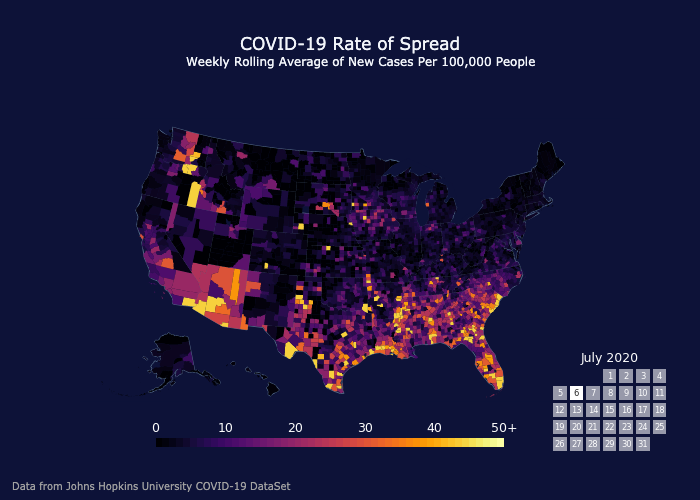

In [150]:
background = draw_single_choropleth(2020, 7,6)
display(background)
#Image(url=make_animation(5, 1, '90D', 'Inferno', 'covid19-county-spread-90day.gif', False))

In [151]:
# Full Generation. Upsamples the data and stores the intermediate pngs on the disk. 
Image(url=make_animation(45, 5, '8H', 'Inferno', 'covid19-county-spread.gif', True))


In [ ]:
[os.system("printf '\a'") for i in range(0, 200)]; # BEEP!


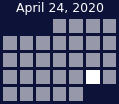

In [43]:
display(get_calendar(2020, 4, 24))

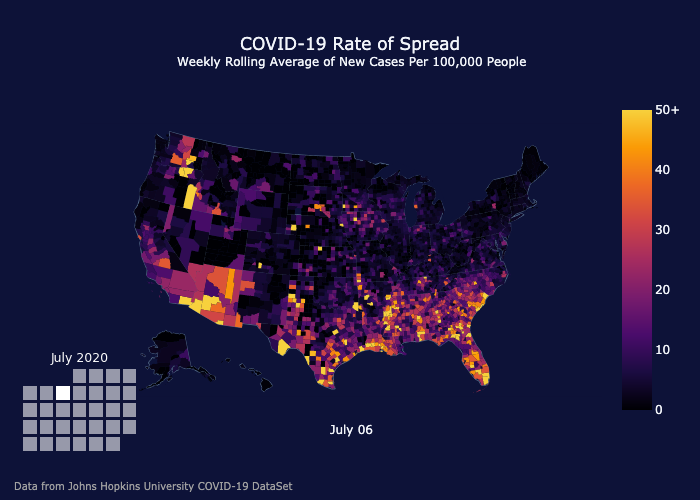

In [14]:
calendar = get_calendar(2020, 7,7)
background = PILImage.open('gitignore-county-spread-images/2020-07-06-00-00.png')
background.paste(calendar, (20,350), calendar)
display(background)

In [38]:
[month%12+1 for month in range(1,13)]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]

In [566]:
h = bgcolor.lstrip('#')
start_color = [tuple(int(h[i:i+2], 16) for i in (0, 2, 4))]
end_color = (255, 255, 255)
spectrum = [a[0] for a in np.linspace(start_color, end_color, 8)]

[array([13., 18., 56.]),
 array([47.57142857, 51.85714286, 84.42857143]),
 array([ 82.14285714,  85.71428571, 112.85714286]),
 array([116.71428571, 119.57142857, 141.28571429]),
 array([151.28571429, 153.42857143, 169.71428571]),
 array([185.85714286, 187.28571429, 198.14285714]),
 array([220.42857143, 221.14285714, 226.57142857]),
 array([255., 255., 255.])]

In [676]:
originalData = get_county_percentages().T.clip(0, 50)

In [152]:
def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.15))
    sns.heatmap(pd.DataFrame([[i] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

In [153]:
display(get_legend())

In [141]:
pd.DataFrame([[i] for i in range(0, 50)]).T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49


In [170]:
datetime.now().day

7

In [191]:
county_percentages = get_county_percentages()

In [194]:
county_percentages.T[48085]

date
2020-03-29     1.325398
2020-03-30     1.325398
2020-03-31     1.587716
2020-04-01     1.808615
2020-04-02     1.946678
                ...    
2020-07-02     9.181139
2020-07-03     9.843838
2020-07-04    10.893111
2020-07-05    10.188993
2020-07-06    10.465118
Name: 48085, Length: 100, dtype: float64

In [195]:
daily_report_data = get_daily_report_data()
daily_report_data

,index,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,FIPS,Admin2,...,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Latitude,Longitude
206,0,NaN,NaN,NaN,51.0,0.0,0.0,2020-06-07,45001,Abbeville,...,US,2020-06-08 03:33:22,34.223334,-82.461707,51.0,"Abbeville, South Carolina, US",207.934113,0.000000,NaN,NaN
207,1,NaN,NaN,NaN,502.0,28.0,0.0,2020-06-07,22001,Acadia,...,US,2020-06-08 03:33:22,30.295065,-92.414197,474.0,"Acadia, Louisiana, US",809.090176,5.577689,NaN,NaN
208,2,NaN,NaN,NaN,983.0,13.0,0.0,2020-06-07,51001,Accomack,...,US,2020-06-08 03:33:22,37.767072,-75.632346,970.0,"Accomack, Virginia, US",3001.609110,1.340206,NaN,NaN
209,3,NaN,NaN,NaN,838.0,22.0,0.0,2020-06-07,16001,Ada,...,US,2020-06-08 03:33:22,43.452658,-116.241552,816.0,"Ada, Idaho, US",174.008019,2.625298,NaN,NaN
210,4,NaN,NaN,NaN,9.0,0.0,0.0,2020-06-07,19001,Adair,...,US,2020-06-08 03:33:22,41.330756,-94.471059,9.0,"Adair, Iowa, US",125.838926,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367354,2855,NaN,NaN,NaN,1.0,0.0,0.0,2020-04-24,2290,Yukon-Koyukuk,...,US,2020-04-25 06:30:53,65.508155,-151.390739,1.0,"Yukon-Koyukuk, Alaska, US",NaN,NaN,NaN,NaN
367355,2856,NaN,NaN,NaN,42.0,1.0,0.0,2020-04-24,4027,Yuma,...,US,2020-04-25 06:30:53,32.768957,-113.906667,41.0,"Yuma, Arizona, US",NaN,NaN,NaN,NaN
367356,2857,NaN,NaN,NaN,6.0,0.0,0.0,2020-04-24,8125,Yuma,...,US,2020-04-25 06:30:53,40.003468,-102.425867,6.0,"Yuma, Colorado, US",NaN,NaN,NaN,NaN
367357,2858,NaN,NaN,NaN,7.0,0.0,0.0,2020-04-24,48505,Zapata,...,US,2020-04-25 06:30:53,27.001564,-99.169872,7.0,"Zapata, Texas, US",NaN,NaN,NaN,NaN


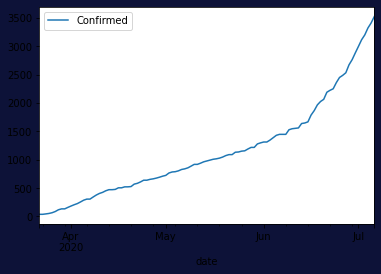

In [213]:
daily_report_data[daily_report_data['FIPS'] == 48085][['date', 'Confirmed']].sort_values(by='date').set_index('date').plot.line()



352.09999999999997

Text(0.5, 1.0, 'July 2020')

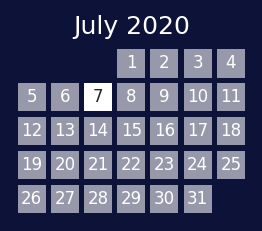

In [47]:
year=2020
month=7
date=7
daysinmonth = (datetime(year, month%12+1,1) - timedelta(days=1)).date().day
weekdaytostart = datetime(year, month, 1).weekday()
weekdayfordate = datetime(year, month, date).weekday()
start_on_sunday = True
sunday_adjustment = 1 if start_on_sunday else 0
days_of_week = [[a[0], a[1]] for a in zip(range(1, daysinmonth+1), [(i+sunday_adjustment+weekdaytostart)%7 for i in range(0, daysinmonth)])]
monthly_calendar_dates = [[None,i] for i in range(0, days_of_week[0][1])] + days_of_week + [[None,i] for i in range(days_of_week[-1][1]+1, 7)]

calendar_data = pd.DataFrame([[j[0] for j in monthly_calendar_dates[i*7:(i*7)+7]] for i in list(range(0, int(len(monthly_calendar_dates)/7)))])
#print(calendar_data)
week_number = calendar_data[calendar_data == date].idxmax(axis=1).idxmax()
day_number = calendar_data[calendar_data == date].idxmax(axis=0).idxmax()
calendar_data_display = pd.DataFrame(calendar_data / calendar_data / 2).fillna(0)

calendar_data_display.iloc[week_number,day_number] = 1
title = '{0:%B %Y}'.format(datetime(year,month,date))

fig, ax = plt.subplots(1, figsize=(2,1.5), dpi=150)
#cmap = get_alpha_blend_cmap('rocket', 0.5)

h = bgcolor.lstrip('#')
start_color = [tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))][0]+(1,)
end_color = (1, 1, 1, 1)
spectrum = [a for a in np.linspace(start_color, end_color, 8)]
cmap = LinearSegmentedColormap.from_list('Custom', spectrum, len(spectrum))

annotations = calendar_data.fillna(0).applymap(lambda x:str(int(x))).replace('0', '')
ax = sns.heatmap(calendar_data_display, linewidths=2, linecolor=bgcolor, cmap=cmap, cbar=False, facecolor=None, ax=ax,
           yticklabels=[], xticklabels=[], annot=annotations, fmt='', annot_kws={"size": 8});

ax.tick_params(axis='both', which='both', length=0)

ax.set(
    xlabel='',
    ylabel=''
)

ax.set_title(title, color='white')


In [43]:
calendar_data.fillna(0).applymap(lambda x:str(int(x))).replace('0', '')

,0,1,2,3,4,5,6
0,,,,1,2,3,4
1,5,6,7,8,9,10,11
2,12,13,14,15,16,17,18
3,19,20,21,22,23,24,25
4,26,27,28,29,30,31,


In [40]:
applymap(7)

NameError: name 'applymap' is not defined

ValueError: cannot convert float NaN to integer

In [116]:
county_percentages = get_county_percentages()
daily_report_data = get_daily_report_data()


In [117]:
%config InlineBackend.print_figure_kwargs={'facecolor' : 'white'}
brazoria_percentages = county_percentages.T[48039]


In [133]:
daily_report_data[daily_report_data['Admin2'] == 'Brazoria']['FIPS'].unique()[0]

48039

In [90]:
brazoria_report_data = daily_report_data[daily_report_data['FIPS'] == 48039][['date', 'Confirmed']].set_index('date').sort_values(by='Confirmed')['Confirmed'].tolist()[7:]
                                                                                                                           

In [109]:
brazoria_comparison = pd.DataFrame([[a[0], a[1], a[2]] for a in list(zip(brazoria_percentages.tolist(), brazoria_report_data, brazoria_percentages.index))], columns=['rate', 'confirmed', 'date'])
brazoria_comparison = brazoria_comparison.set_index('date')

In [112]:
pd.set_option('display.max_rows', 150)
brazoria_comparison['diff'] = brazoria_comparison['confirmed'].diff()

In [118]:
brazoria_percentages

date
2020-03-29     1.793997
2020-03-30     1.984848
2020-03-31     2.557400
2020-04-01     2.557400
2020-04-02     2.671911
2020-04-03     3.206293
2020-04-04     3.168123
2020-04-05     3.168123
2020-04-06     3.778845
2020-04-07     2.977272
2020-04-08     2.977272
2020-04-09     2.862762
2020-04-10     2.900932
2020-04-11     2.748251
2020-04-12     3.091782
2020-04-13     2.671911
2020-04-14     2.939102
2020-04-15     3.282633
2020-04-16     3.358973
2020-04-17     3.282633
2020-04-18     3.282633
2020-04-19     3.015442
2020-04-20     2.977272
2020-04-21     3.168123
2020-04-22     3.282633
2020-04-23     4.580418
2020-04-24     5.038460
2020-04-25     4.389568
2020-04-26     5.381992
2020-04-27     5.114801
2020-04-28     5.000290
2020-04-29     5.000290
2020-04-30     3.549824
2020-05-01     3.511654
2020-05-02     4.580418
2020-05-03     3.702505
2020-05-04     3.893356
2020-05-05     3.893356
2020-05-06     4.275057
2020-05-07     3.931526
2020-05-08     3.969696
2020-05-09 

In [120]:
df1 = (
    daily_report_data
    [['Confirmed', 'FIPS', 'date']] # Keep these three columns
    .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
    .drop_duplicates(['date','fips']) # There are a few duplicates. Drop them. 
    .pivot(values='confirmed', index='date', columns='fips') # Create the pivot table. 
    .fillna(0)
    .diff()
    .rolling(window=7)
    .mean()
    .dropna()
    .T
)

df2 = get_census_info()
(df1.div(df2.iloc[:,0], axis=0).dropna()) * 100000

date,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,...,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06
fips,,,,,,,,,,,,,,,,,,,,,
1001,1.534201,1.534201,1.534201,1.022801,1.022801,1.534201,1.534201,1.534201,1.534201,1.278501,...,17.131913,17.643314,21.734517,21.223116,20.967416,20.456016,19.944615,23.268718,28.127022,22.757318
1003,0.831927,0.959915,0.959915,1.023910,1.215893,1.471870,1.215893,0.895921,1.279887,1.471870,...,8.575243,9.215186,13.054847,14.590711,15.166660,17.470457,20.990146,19.646265,19.518276,17.150485
1005,0.000000,0.000000,0.000000,0.000000,0.000000,0.578697,1.157394,1.157394,1.157394,1.736091,...,24.883971,24.883971,24.883971,24.883971,20.833092,17.360910,20.833092,19.097001,20.254395,19.675698
1007,0.000000,1.275852,1.913778,1.913778,2.551704,2.551704,2.551704,3.189630,3.189630,3.189630,...,22.327409,22.327409,22.965335,22.327409,21.051557,19.137779,22.965335,18.499853,19.775705,20.413631
1009,1.235233,1.235233,1.235233,0.988186,0.988186,1.235233,1.235233,1.235233,1.235233,1.235233,...,11.117095,9.881862,11.364142,11.858235,12.105281,11.117095,11.117095,11.117095,12.105281,11.611188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.337381,0.337381,0.674762,0.337381,0.674762,0.674762,1.012142,1.349523,1.349523,1.012142,...,10.796185,9.784043,10.121423,10.796185,8.097139,6.410235,6.747616,7.084996,8.097139,9.109281
56039,7.306025,8.523696,10.959038,12.785544,13.394379,13.394379,14.003215,15.220885,14.612050,12.785544,...,6.088354,7.914860,10.350202,9.741367,10.959038,10.959038,9.741367,10.959038,10.350202,10.350202
56041,0.000000,0.000000,0.000000,0.000000,0.706304,0.706304,1.412609,1.412609,2.118913,2.118913,...,26.133266,21.189134,18.363916,16.951307,14.126089,12.713481,11.300872,11.300872,11.300872,11.300872


In [122]:
df1.T[48039]

date
2020-03-29      6.714286
2020-03-30      7.428571
2020-03-31      9.571429
2020-04-01      9.571429
2020-04-02     10.000000
2020-04-03     12.000000
2020-04-04     11.857143
2020-04-05     11.857143
2020-04-06     14.142857
2020-04-07     11.142857
2020-04-08     11.142857
2020-04-09     10.714286
2020-04-10     10.857143
2020-04-11     10.285714
2020-04-12     11.571429
2020-04-13     10.000000
2020-04-14     11.000000
2020-04-15     12.285714
2020-04-16     12.571429
2020-04-17     12.285714
2020-04-18     12.285714
2020-04-19     11.285714
2020-04-20     11.142857
2020-04-21     11.857143
2020-04-22     12.285714
2020-04-23     17.142857
2020-04-24     18.857143
2020-04-25     16.428571
2020-04-26     20.142857
2020-04-27     19.142857
2020-04-28     18.714286
2020-04-29     18.714286
2020-04-30     13.285714
2020-05-01     13.142857
2020-05-02     17.142857
2020-05-03     13.857143
2020-05-04     14.571429
2020-05-05     14.571429
2020-05-06     16.000000
2020-05-07     14.71

In [144]:
starter = (
    daily_report_data
    [['Confirmed', 'FIPS', 'date']] # Keep these three columns
    .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
    .drop_duplicates(['date','fips']) # There are a few duplicates. Drop them. 
    .pivot(values='confirmed', index='date', columns='fips') # Create the pivot table. 
    .fillna(0)
)
df1 = (
    starter[starter >= starter.cummax()]
    .interpolate()
    .diff()
    .rolling(window=7)
    .mean()
    .dropna()
    .T
)

df2 = get_census_info()
result = (df1.div(df2.iloc[:,0], axis=0).dropna()) * 100000

In [146]:
result.T[48039]

date
2020-03-29     1.793997
2020-03-30     1.984848
2020-03-31     2.557400
2020-04-01     2.557400
2020-04-02     2.671911
2020-04-03     3.206293
2020-04-04     3.168123
2020-04-05     3.168123
2020-04-06     3.778845
2020-04-07     2.977272
2020-04-08     2.977272
2020-04-09     2.862762
2020-04-10     2.900932
2020-04-11     2.748251
2020-04-12     3.091782
2020-04-13     2.671911
2020-04-14     2.939102
2020-04-15     3.282633
2020-04-16     3.358973
2020-04-17     3.282633
2020-04-18     3.282633
2020-04-19     3.015442
2020-04-20     2.977272
2020-04-21     3.168123
2020-04-22     3.282633
2020-04-23     4.580418
2020-04-24     5.038460
2020-04-25     4.389568
2020-04-26     5.381992
2020-04-27     5.114801
2020-04-28     5.000290
2020-04-29     5.000290
2020-04-30     3.549824
2020-05-01     3.511654
2020-05-02     4.580418
2020-05-03     3.702505
2020-05-04     3.893356
2020-05-05     3.893356
2020-05-06     4.275057
2020-05-07     3.931526
2020-05-08     3.969696
2020-05-09 